In this notebook we'll train a classifier to find **point behaviors** in inertial sensor data.

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sktime.classification.compose import TimeSeriesForestClassifier, ColumnEnsembleClassifier
from sktime.utils.data_container import from_3d_numpy_to_nested
from typing import List, Tuple

rg = np.random.Generator(np.random.PCG64(1134))
def flatten(list_of_lists: List[List]) -> List:
    """
    Flatten a list of lists
    
        Parameters: 
            list_of_lists: a nested list
        
        Return:
            A flattened list 
    
    """
    return [i for sublist in list_of_lists for i in sublist]

def assert_shape(x: np.ndarray, shape: List[int]):
    """ 
    Assert shape of ndarray. Via https://medium.com/@nearlydaniel/assertion-of-arbitrary-array-shapes-in-python-3c96f6b7ccb4
    
        Parameters:
            x: ndarray for shape assertion
            shape: shape specification
    """
    assert len(x.shape) == len(shape), (x.shape, shape)
    for _a, _b in zip(x.shape, shape):
        if isinstance(_b, int):
            assert _a == _b, (x.shape, shape)

def assert_dtype(x: np.ndarray, dtype: np.dtype):
    """
    Assert dtype of ndarray.
    
        Parameters:
            x: ndarray for dtype assertion
            dtype: dtype specification
    """
    assert issubclass(x.dtype.type, dtype), (x.dtype.type, dtype)

Generate dummy sensor data and randomly assign events

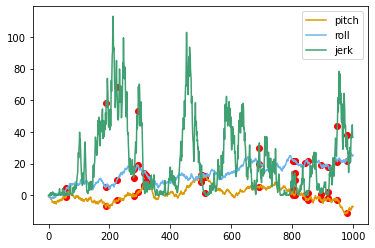

In [2]:
def random_sensor(n):
    return rg.uniform(low=-1., high=1., size=n).cumsum()
N = 1000
sensors = pd.DataFrame(
    {
        "pitch": random_sensor(N),
        "roll": random_sensor(N),
        "jerk": random_sensor(N)**2
    }
)
N_events = 20
events = rg.choice(range(N), size=N_events, replace=False)
events.sort()

# Plot dummy sensor data
sensors.plot.line(y=["pitch", "roll", "jerk"], color=["#DD9A00", "#6AB5EC", "#3FA072"])
for y in ["pitch", "roll", "jerk"]:
    plt.scatter(x=events, y=y, data=sensors.iloc[events], marker="o", color="red")

# How do I make the red points appear over the lines?

Create the training dataset consisting of **all** positive (i.e., the events) and an equal sample size of negatives (randomly selected). We'll use 20 record windows and make sure negative sample windows don't overlap the positives.

In [3]:
# Negatives must be 10 records removed from a positive
win_size = 20
positives = events

def diff_from(xs: np.ndarray, ys: np.ndarray) -> np.ndarray:
    """
    Return the array-wise least difference from another array
    
        Parameters:
            xs: the basis array
            ys: the target array
            
        Returns:
            The minimum absolute difference for each element of xs from the closest value in ys
    """
    return np.array([np.min(np.abs(x - ys)) for x in xs])

# Valid indices for negatives
negative_choices = np.array(range(win_size, len(sensors.index) - win_size - 1, win_size))
diff_from_pos = diff_from(negative_choices, positives)
negative_choices = negative_choices[diff_from_pos > win_size]

# Randomly choose 
negatives = rg.choice(negative_choices, size=len(positives), replace=False)
negatives.sort()

print("+: " + str(positives))
print("-: " + str(negatives))

+: [ 58 189 224 279 294 312 321 499 503 514 691 803 808 809 842 850 894 918
 948 978]
-: [ 20  80 100 120 140 160 360 380 400 440 460 540 560 580 600 660 720 740
 760 780]


Convert positives and negatives to sktime-compatible format

In [4]:
def extract_nested(data: pd.DataFrame, idx: np.ndarray, window_size: int) -> pd.DataFrame:
    """
    Extract samples from longitudinal sensor data and reformat into nested sktime DataFrame format
    
        Parameters:
            data: longitudinal sensor data
            idx: indices of sample centers
            window_size: number of records in each sample window
        
        Returns:
            Sample windows in nested sktime DataFrame format
    """
    assert_shape(idx, [None])
    assert_dtype(idx, np.integer)
    assert idx.min() >= int(window_size / 2), "idx out of bounds"
    assert idx.max() < len(data) - int(window_size / 2), "idx out of bounds"
    
    # Create a 3d numpy array of window data
    data_3d = np.empty([len(idx), len(data.columns), window_size], float)
    data_arr = data.to_numpy().transpose()
    start_idx = idx - int(window_size / 2)
    for i, start in enumerate(start_idx):
        data_3d[i] = data_arr[:, start:(start + window_size)]

    # Convert 3d numpy array to nested sktime DataFrame format
    nested = from_3d_numpy_to_nested(data_3d)
    nested.columns = data.columns
    nested.index = idx
    
    return nested

nested_positives = extract_nested(sensors, positives, win_size)
nested_negatives = extract_nested(sensors, negatives, win_size)
clf_data = pd.concat([nested_positives, nested_negatives])
clf_labels = ["pos"] * len(nested_positives) + ["neg"] * len(nested_negatives)
display(clf_data.head())
print(clf_labels[0:5])

,pitch,roll,jerk
58,0 -1.646066 1 -1.036965 2 -1.417835 3...,0 0.832445 1 1.559267 2 2.514803 3...,0 0.495073 1 0.165041 2 0.540158 3...
189,0 -4.328258 1 -4.268212 2 -4.405030 3...,0 7.819986 1 7.773262 2 7.326560 3...,0 35.851711 1 37.600007 2 47.14075...
224,0 -2.963541 1 -3.090911 2 -3.376539 3...,0 6.194446 1 5.291603 2 5.86817...,0 91.898686 1 92.978432 2 78.44859...
279,0 0.118213 1 0.725500 2 -0.022379 3...,0 19.067221 1 18.156301 2 17.32493...,0 18.473871 1 13.171670 2 18.26273...
294,0 0.325656 1 0.098551 2 -0.763982 3...,0 15.697729 1 16.024445 2 16.55290...,0 25.979500 1 29.165037 2 33.63423...


['pos', 'pos', 'pos', 'pos', 'pos']


Fit a ColumnEnsembleClassifier composed of TimeSeriesForest estimators

In [5]:
clf = ColumnEnsembleClassifier(
    estimators=[("TSF_" + c, TimeSeriesForestClassifier(n_estimators=100), [i]) 
                for i, c in enumerate(clf_data.columns)]
)
X_train, X_test, y_train, y_test = train_test_split(clf_data, clf_labels, random_state=42)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5

Use model to predict on entire longitudinal sensor data set

In [6]:
def nest_all(data: pd.DataFrame, window_size: int, exclude: np.ndarray = None) -> pd.DataFrame:
    """
    Convert longitudinal sensor data into nested sktime DataFrame format
    
        Parameters:
            data: longitudinal sensor data
            window_size: number of records in each window
            exclude: indices to exclude (None by default)
            
        Return:
            Windows in nested sktime DataFrame format
    """
    assert_shape(exclude, [None])
    assert_dtype(exclude, np.integer)
    
    idx = np.array(range(int(window_size / 2), len(data) - int(window_size / 2)))
    if exclude is not None:
        idx = np.setdiff1d(idx, exclude)
    return extract_nested(data, idx, window_size)

sensors_nested = nest_all(sensors, win_size, exclude=np.array(range(10, 100)))
sensors_nested.head()

proba = clf.predict_proba(sensors_nested)

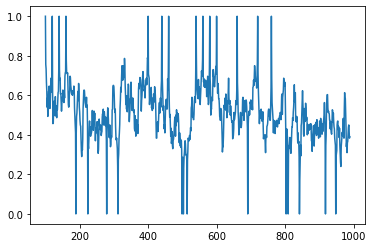

In [14]:
plt.plot(sensors_nested.index, proba[:, 0])